### XGBoost Model - Optimized
Optimized using BayesSearchCV and SHAP/LIME

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import shap
import lime
from IPython.display import HTML, display

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your preprocessed data 
df = pd.read_csv('/Users/amalshar/Desktop/USD/Spring 2025/Artificial Intelligence/AI Project/data/energy_weather_preprocessed.csv')

# Prepare data
target = 'active_power'
y = df[target]
X = df.drop(target, axis=1)

# Remove NaN values
X = X.dropna()
y = y[X.index]

# Split data (time-based split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [3]:
# Define search space for Bayesian Optimization
search_spaces = {
    'n_estimators': Integer(100, 300),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 5),
    'subsample': Real(0.7, 0.9),
    'colsample_bytree': Real(0.7, 0.9),
    'gamma': Real(0, 0.2)
}

In [4]:
# Initialize XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize BayesSearchCV
opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=50,  # Number of optimization iterations
    cv=5,      # Cross-validation folds
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Run the optimization
opt.fit(X_train, y_train)

# Get the best parameters
best_params = opt.best_params_
print(f'Best Parameters: {best_params}')

# Get the best model
best_model = opt.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.7820207917706627, gamma=0.14554514863546503, learning_rate=0.08567773934012718, max_depth=4, n_estimators=234, subsample=0.7828237264971076; total time=  10.1s
[CV] END colsample_bytree=0.7820207917706627, gamma=0.14554514863546503, learning_rate=0.08567773934012718, max_depth=4, n_estimators=234, subsample=0.7828237264971076; total time=   9.6s
[CV] END colsample_bytree=0.7820207917706627, gamma=0.14554514863546503, learning_rate=0.08567773934012718, max_depth=4, n_estimators=234, subsample=0.7828237264971076; total time=   9.9s
[CV] END colsample_bytree=0.7820207917706627, gamma=0.14554514863546503, learning_rate=0.08567773934012718, max_depth=4, n_estimators=234, subsample=0.7828237264971076; total time=   9.7s
[CV] END colsample_bytree=0.7820207917706627, gamma=0.14554514863546503, learning_rate=0.08567773934012718, max_depth=4, n_estimators=234, subsample=0.7828237264971076; total time=   9.9s
F

In [5]:
# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 1.4850370885296098e-05
Mean Absolute Error (MAE): 0.0012871080276779467
R-squared (R2): 0.9959555526463291


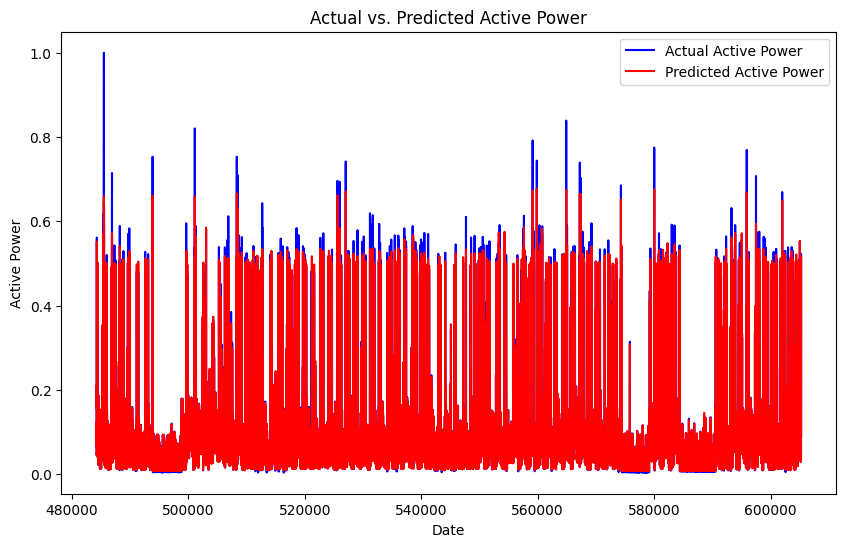

In [6]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Active Power', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Active Power', color='red')
plt.xlabel('Date')
plt.ylabel('Active Power')
plt.title('Actual vs. Predicted Active Power')
plt.legend()
plt.show()

In [7]:
# 4. Feature Importance
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('\nFeature Importance:\n', feature_importance_df)


Feature Importance:
                                 Feature  Importance
3                        apparent_power    0.747148
0                               current    0.177641
15                   active_power_lag_1    0.021502
16                   active_power_lag_2    0.008343
19             active_power_rolling_std    0.007654
4                          power_factor    0.007386
18            active_power_rolling_mean    0.006572
17                   active_power_lag_3    0.005904
2                        reactive_power    0.002627
7                              temp_min    0.002465
8                              temp_max    0.001987
1                               voltage    0.001421
22                                month    0.001216
21                                  day    0.000989
10                             humidity    0.000935
11                                speed    0.000924
14                       feels_like_t+1    0.000873
6                            feels_like   

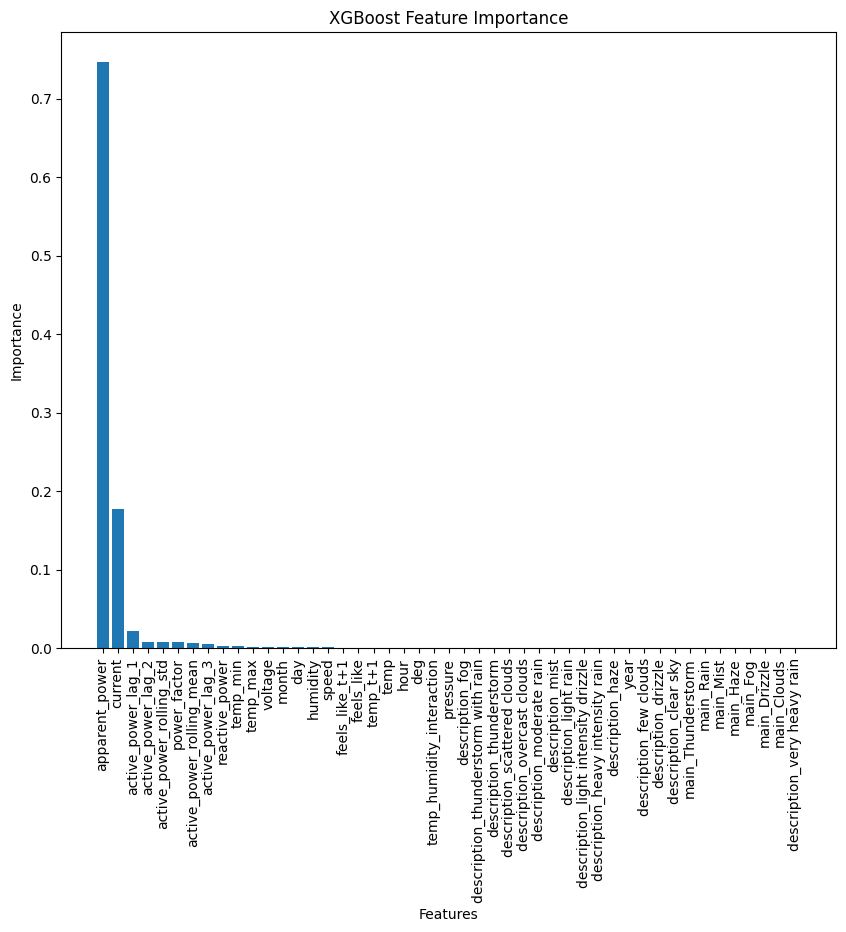

In [8]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')
plt.show()

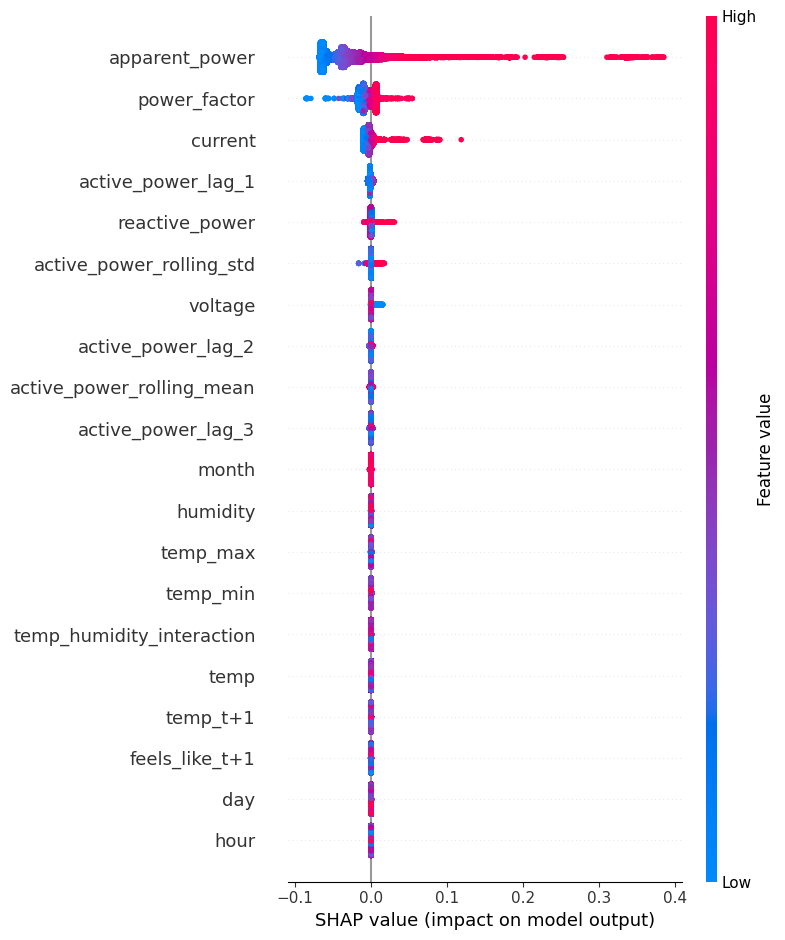

In [10]:
# Create a SHAP TreeExplainer for the best model
explainer = shap.TreeExplainer(best_model)

# Obtain SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot: displays feature importance and the effect on the model output
shap.summary_plot(shap_values, X_test, plot_type="dot")

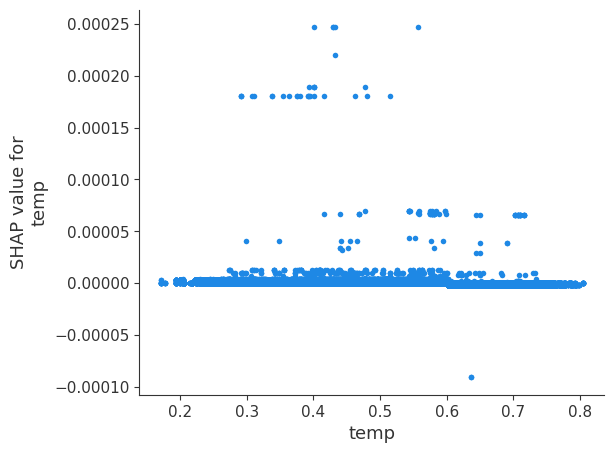

In [12]:
# Dependence plot for a single feature
shap.dependence_plot("temp", shap_values, X_test, interaction_index=None)

# Show plots
plt.show()

In [13]:
# Create a LIME Tabular Explainer based on training data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

In [15]:
i = 0  # Change index as needed for a different test instance
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=best_model.predict, 
    num_features=20
)

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

In [16]:
# Print the explanation as a list
print("LIME Explanation:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight}")

# Save the explanation as HTML and display it
html_output = exp.as_html()
with open("exp13_lime_explanation.html", "w") as f:
    f.write(html_output)

LIME Explanation:
0.06 < apparent_power <= 0.09: -0.03903752387691832
description_moderate rain <= 0.00: 0.038203227255403246
description_drizzle <= 0.00: -0.027833954215823596
description_light rain <= 0.00: -0.02508938827414669
main_Rain <= 0.00: 0.024360076247905215
power_factor <= 0.81: -0.01857640748158318
main_Thunderstorm <= 0.00: 0.015247951837545699
description_light intensity drizzle <= 0.00: 0.008658326495942033
description_thunderstorm <= 0.00: -0.008551613034473883
0.29 < humidity <= 0.43: 0.005393900545626333
0.06 < current <= 0.09: -0.005000911622046766
main_Haze <= 0.00: 0.004648354584276058
main_Mist <= 0.00: 0.004636499332740643
description_mist <= 0.00: -0.004026194133257077
4.65 < active_power_rolling_std <= 70.56: -0.003833286774479849
main_Fog <= 0.00: 0.00341311986003645
0.00 < description_clear sky <= 1.00: 0.003043729485399031
deg <= 32.00: -0.0027650206549210857
active_power_lag_1 <= 175.90: -0.002634416626470392
main_Drizzle <= 0.00: -0.0026235043698773623


In [17]:
# Style the explanation with a white background
html_output = exp.as_html()
styled_html = f"""
<div style="background-color: white; padding: 20px; border: 1px solid black; border-radius: 5px;">
    {html_output}
</div>
"""

# Display the styled explanation in the notebook
display(HTML(styled_html))